In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Tensorflow Version 2.1.0


In [2]:
df = pd.read_csv('../input/covid19-tweet-classification-challenge-by-zindi/updated_train.csv',
                 encoding = 'latin')
df.head()

,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0


In [3]:
df.target.value_counts()

0    2746
1    2541
Name: target, dtype: int64

In [4]:
df = df.drop(['ID'], axis=1)

In [5]:
lab_to_sentiment = {0:"not_covid-19-related", 1:"covid-19-related"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.target = df.target.apply(lambda x: label_decoder(x))
df.head()

,text,target
0,The bitcoin halving is cancelled due to,covid-19-related
1,MercyOfAllah In good times wrapped in its gran...,not_covid-19-related
2,266 Days No Digital India No Murder of e learn...,covid-19-related
3,India is likely to run out of the remaining RN...,covid-19-related
4,In these tough times the best way to grow is t...,not_covid-19-related


Text(0.5, 1.0, 'Sentiment Data Distribution')

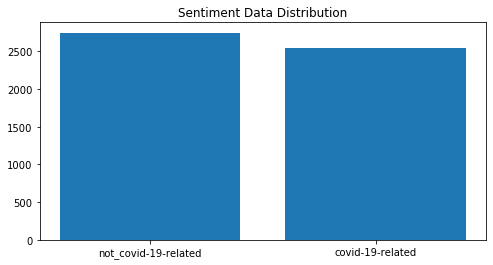

In [6]:
val_count = df.target.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [7]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,text,target
5240,There are many Muslims who were with us last R...,not_covid-19-related
2636,gt gt gt When you wear a sports bra to bed amp...,not_covid-19-related
569,This International Day of Action for Women s H...,covid-19-related
132,Given you have such a huge Indian community yo...,covid-19-related
1274,Understand Tensors and Matrices,not_covid-19-related
662,Would love to speak to Muslim women who have r...,not_covid-19-related
4095,show luv gonna try and get this going as a pla...,not_covid-19-related
4148,BBC News Germans don compulsory masks as lockd...,covid-19-related
3016,Get up to Speed with and Transformers Techniqu...,not_covid-19-related
1968,Ans Wilson Lionel Garton Jones Username photog...,not_covid-19-related


In [8]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [9]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [10]:
df.text = df.text.apply(lambda x: preprocess(x))

## Train and Test Split

In [13]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [14]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 4229
Test Data size 1058


In [15]:
train_data.head(2)

,text,target
3145,myth circulates online symptoms progress three...,covid-19-related
2253,nascar backstories surface 1 hit wonders,not_covid-19-related


In [16]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Using TensorFlow backend.


Vocabulary Size : 12440


In [17]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (4229, 30)
Testing X Shape: (1058, 30)


In [18]:
labels = train_data.target.unique().tolist()

In [19]:
encoder = LabelEncoder()
encoder.fit(train_data.target.to_list())

y_train = encoder.transform(train_data.target.to_list())
y_test = encoder.transform(test_data.target.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (4229, 1)
y_test shape: (1058, 1)


In [23]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-08-29 08:41:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-29 08:41:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-29 08:41:03--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [24]:
GLOVE_EMB = "./glove.6B.100d.txt"
EMBEDDING_DIM = 100
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = 'nlptown/bert-base-multilingual-uncased-sentiment'

In [25]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [26]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [27]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [28]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [29]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [30]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

In [32]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Train on 4229 samples, validate on 1058 samples
Epoch 1/10
4229/4229 [==============================] - 11s 3ms/sample - loss: 0.6784 - accuracy: 0.5860 - val_loss: 0.6076 - val_accuracy: 0.7278
Epoch 2/10
4229/4229 [==============================] - 1s 132us/sample - loss: 0.5647 - accuracy: 0.7389 - val_loss: 0.4450 - val_accuracy: 0.7921
Epoch 3/10
4229/4229 [==============================] - 1s 136us/sample - loss: 0.4833 - accuracy: 0.7860 - val_loss: 0.4338 - val_accuracy: 0.8119
Epoch 4/10
4229/4229 [==============================] - 1s 134us/sample - loss: 0.4501 - accuracy: 0.7952 - val_loss: 0.4546 - val_accuracy: 0.8015
Epoch 5/10
4229/4229 [==============================] - 1s 136us/sample - loss: 0.4384 - accuracy: 0.8044 - val_loss: 0.4013 - val_accuracy: 0.8214
Epoch 6/10
4229/4229 [==============================] - 1s 133us/sample - loss: 0.4060 - accuracy: 0.8208 - val_loss: 0.3937 - val_accuracy: 0.8289
Epoch 7/10
4229/4229 [==============================] - 1s 133us/

In [51]:
test=pd.read_csv("../input/covid19-tweet-classification-challenge-by-zindi/updated_test.csv")
sub=pd.read_csv("../input/covid19-tweet-classification-challenge-by-zindi/updated_ss.csv")
id_=test["ID"]

In [52]:
xtest = pad_sequences(tokenizer.texts_to_sequences(test.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

In [53]:
pred = model.predict(xtest, verbose=1, batch_size=10000)

1962/1962 [==============================] - 0s 52us/sample


In [55]:
len(pred)

1962

In [57]:
sub.target=pred
from IPython.display import FileLink
def create_submission(submission_file, submission_name):
    submission_file.to_csv(submission_name+".csv",index=False)
    return FileLink(submission_name+".csv")
create_submission(sub, "sol")

/kaggle/working/sol.csv